In [1]:
# 1. Imports and Data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import multivariate_normal

# Create synthetic data with varied covariance
X, y_true = make_blobs(n_samples=500, centers=3, cluster_std=[1.0, 2.5, 0.5], random_state=42)

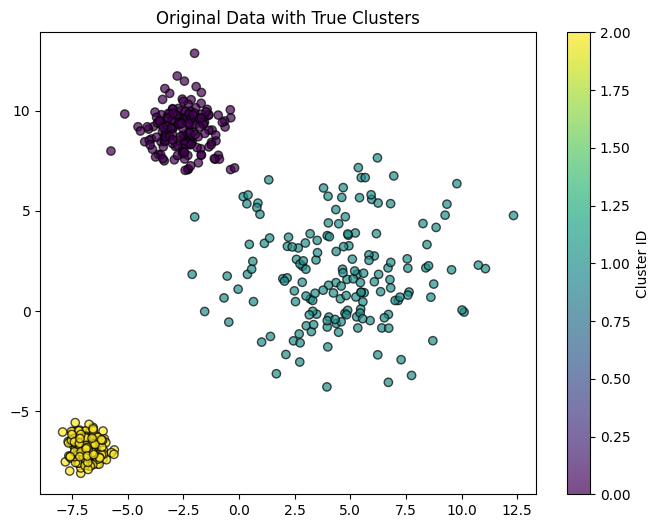

In [2]:
# 2. Data Visualization
# Show original data distribution with ground truth

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', edgecolors='k', alpha=0.7)
plt.title("Original Data with True Clusters")
plt.colorbar(label="Cluster ID")
plt.show()

In [3]:
# 3. Data Preprocessing
# Standardize features for covariance analysis

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

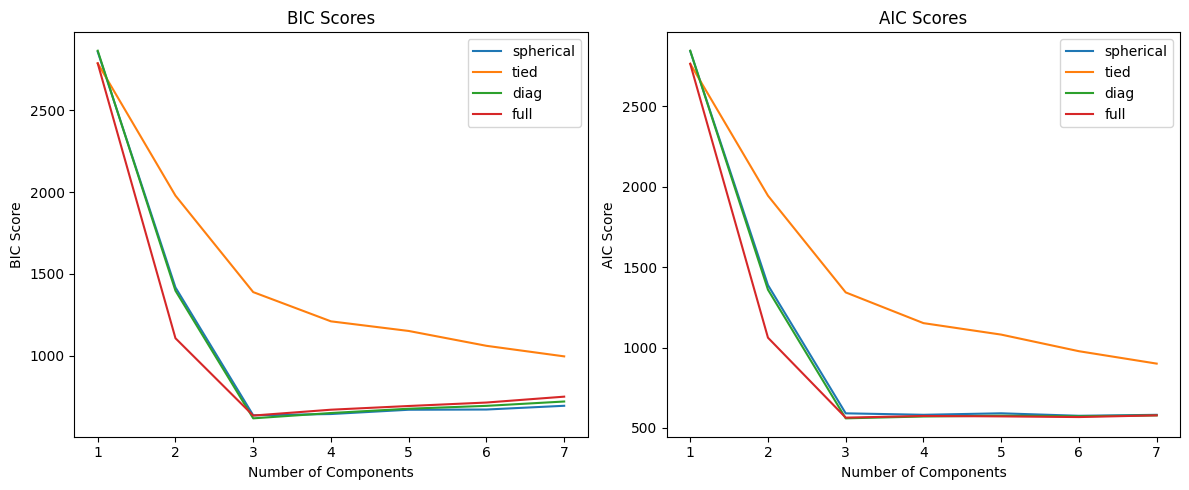

In [4]:
# 4. Model Selection Using BIC/AIC
# Determine optimal components and covariance type

n_components_range = range(1, 8)
covariance_types = ['spherical', 'tied', 'diag', 'full']
bic_scores = []
aic_scores = []

for cov_type in covariance_types:
    bic = []
    aic = []
    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, covariance_type=cov_type, random_state=42)
        gmm.fit(X_scaled)
        bic.append(gmm.bic(X_scaled))
        aic.append(gmm.aic(X_scaled))
    bic_scores.append(bic)
    aic_scores.append(aic)

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, cov_type in enumerate(covariance_types):
    plt.plot(n_components_range, bic_scores[i], label=cov_type)
plt.title("BIC Scores")
plt.xlabel("Number of Components")
plt.ylabel("BIC Score")
plt.legend()

plt.subplot(1, 2, 2)
for i, cov_type in enumerate(covariance_types):
    plt.plot(n_components_range, aic_scores[i], label=cov_type)
plt.title("AIC Scores")
plt.xlabel("Number of Components")
plt.ylabel("AIC Score")
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# 5. Final Model Training
# Select best parameters from analysis

best_n_components = 3  # Known ground truth
best_cov_type = 'full'  # Most flexible covariance

final_gmm = GaussianMixture(
    n_components=best_n_components,
    covariance_type=best_cov_type,
    random_state=42
)
final_gmm.fit(X_scaled)
gmm_labels = final_gmm.predict(X_scaled)

Silhouette Score: 0.768
Adjusted Rand Index: 1.000


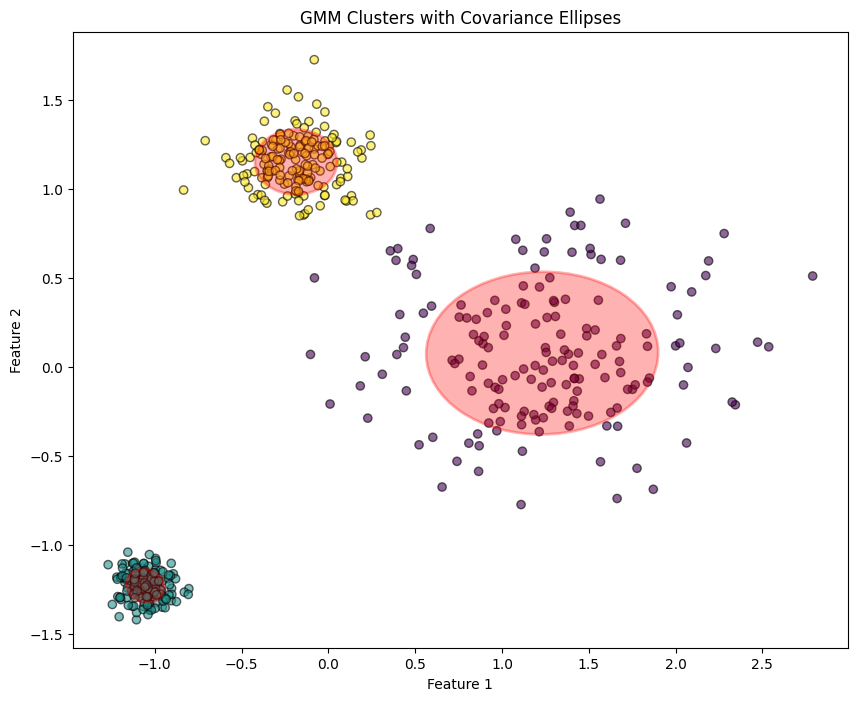

In [6]:
# 6. Results Evaluation
# Clustering quality and visualize distributions

# Calculate scores
sil_score = silhouette_score(X_scaled, gmm_labels)
ari_score = adjusted_rand_score(y_true, gmm_labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Adjusted Rand Index: {ari_score:.3f}")

# Visualization
def plot_gmm(gmm, X):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', edgecolors='k', alpha=0.6)

    # Plot covariance ellipses
    for i in range(gmm.n_components):
        mean = gmm.means_[i]
        cov = gmm.covariances_[i]

        if gmm.covariance_type == 'spherical':
            cov = np.eye(X.shape[1]) * cov
        elif gmm.covariance_type == 'tied':
            cov = gmm.covariances_
        elif gmm.covariance_type == 'diag':
            cov = np.diag(cov)

        v, w = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(w[0][1], w[0][0]))
        v = 2.5 * np.sqrt(v)  # 2.5σ for 98% coverage

        ellipse = plt.matplotlib.patches.Ellipse(
            mean, v[0], v[1], angle=180 + angle,
            color='red', alpha=0.3, lw=2
        )
        ax.add_patch(ellipse)

    plt.title("GMM Clusters with Covariance Ellipses")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_gmm(final_gmm, X_scaled)

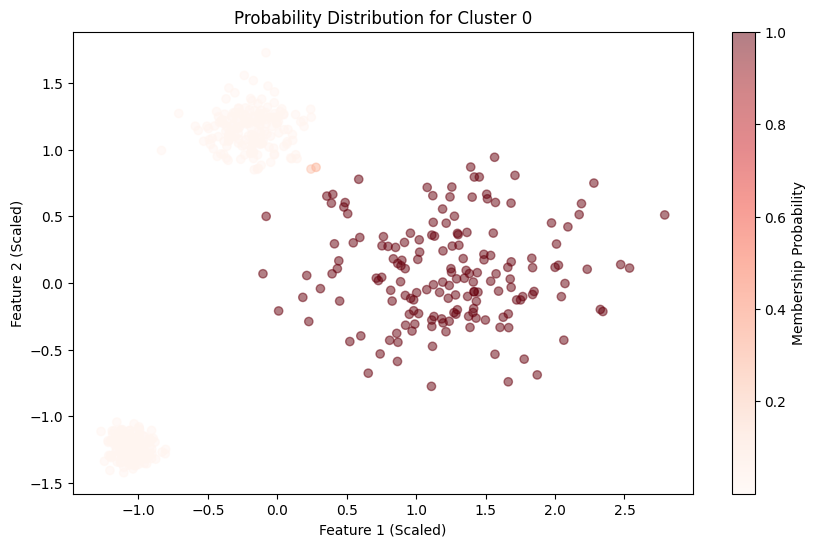

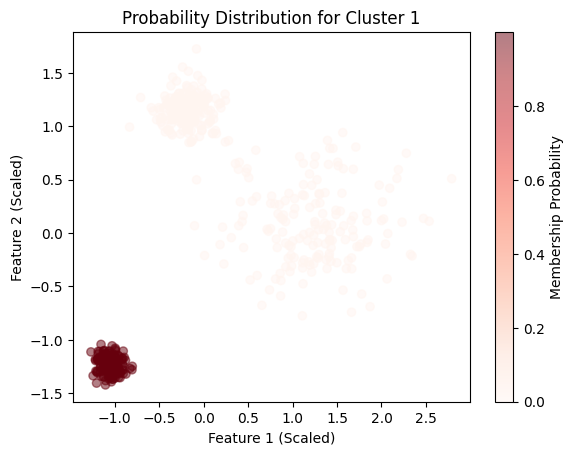

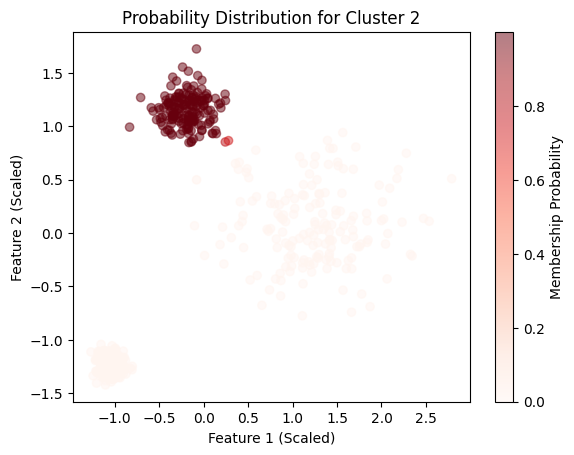

In [7]:
# 7. Probability Analysis
# Soft clustering probabilities

# Get cluster probabilities
probs = final_gmm.predict_proba(X_scaled)

# Visualize probability distribution
plt.figure(figsize=(10, 6))
for i in range(best_n_components):
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=probs[:, i], cmap='Reds', alpha=0.5)
    plt.title(f"Probability Distribution for Cluster {i}")
    plt.colorbar(label="Membership Probability")
    plt.xlabel("Feature 1 (Scaled)")
    plt.ylabel("Feature 2 (Scaled)")
    plt.show()